In [120]:
from pathlib import Path
from urllib.request import urlretrieve

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import requests
from typing import Dict, List, Union, Optional

import pandas as pd
import geopandas as gpd

In [147]:
POST_DIR = Path(".").resolve()

The US Census bureau collects and publishes a massive amount of interesting data, including a lot of rich geospatial data. I want to integrate a lot of these datasets into my personal [analytics data warehouse](https://github.com/MattTriano/analytics_data_where_house/tree/main), and in this notebook, I'm going to work on scraping down metadata from geospatial-file-related pages on the Census's [file server](https://www2.census.gov/).

I'm also a big fan of `Geopandas`, and I'll show off some of the things it can do in this notebook.

In [61]:
def request_page(metadata_url: str) -> requests.models.Response:
    resp = requests.get(metadata_url)
    if resp.status_code == 200:
        return resp
    else:
        raise Exception(f"Couldn't get page metadata for url {metadata_url}")

def scrape_census_ftp_metadata_page(metadata_url: str) -> pd.DataFrame:
    resp = request_page(metadata_url=metadata_url)
    soup = BeautifulSoup(resp.content, "html.parser")
    table = soup.find("table")
    rows = table.find_all("tr")
    table_contents = []
    for row in rows:
        cols = row.find_all("td")
        cols = [col.text.strip() for col in cols]
        table_contents.append(cols)
    table_rows = [el for el in table_contents if len(el) > 0]

    metadata_df = pd.DataFrame(
        [row[1:] for row in table_rows],
        columns=["name", "last_modified", "size", "description"],
    )
    metadata_df["last_modified"] = pd.to_datetime(metadata_df["last_modified"])
    metadata_df["is_dir"] = metadata_df["name"].str.endswith("/")
    metadata_df["clean_name"] = metadata_df["name"].str.replace("/$", "", regex=True)
    metadata_df["is_file"] = (~metadata_df["is_dir"]) & (
        metadata_df["clean_name"] != "Parent Directory"
    )
    while metadata_url.strip().endswith("/"):
        metadata_url = metadata_url[:-1]
    mask = metadata_df["is_file"] | metadata_df["is_dir"]
    metadata_df = metadata_df.loc[mask].copy()
    metadata_df["metadata_url"] = (metadata_url + "/" + metadata_df["clean_name"])
    return metadata_df

In [55]:
tiger_url = "https://www2.census.gov/geo/tiger/"
metadata_url = tiger_url
tiger_top_level_df = scrape_census_ftp_metadata_page(metadata_url=metadata_url)

In [57]:
tiger_top_level_df = tiger_top_level_df.sort_values(by="last_modified", ascending=False, ignore_index=True)

In [60]:
print(tiger_top_level_df.shape)
tiger_top_level_df.head(10)

(60, 8)


,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
0,GENZ2020/,2023-05-18 20:05:00,-,,True,GENZ2020,False,https://www2.census.gov/geo/tiger/GENZ2020
1,GENZ2022/,2023-04-17 14:38:00,-,,True,GENZ2022,False,https://www2.census.gov/geo/tiger/GENZ2022
2,TIGER_DP/,2023-03-16 11:50:00,-,,True,TIGER_DP,False,https://www2.census.gov/geo/tiger/TIGER_DP
3,TGRGDBRD18/,2023-01-26 15:28:00,-,,True,TGRGDBRD18,False,https://www2.census.gov/geo/tiger/TGRGDBRD18
4,TGRGDB18/,2023-01-26 11:49:00,-,,True,TGRGDB18,False,https://www2.census.gov/geo/tiger/TGRGDB18
5,TIGER_RD18/,2022-12-05 15:10:00,-,,True,TIGER_RD18,False,https://www2.census.gov/geo/tiger/TIGER_RD18
6,TIGER2022/,2022-11-01 08:09:00,-,,True,TIGER2022,False,https://www2.census.gov/geo/tiger/TIGER2022
7,TIGER2021/,2022-09-01 12:16:00,-,,True,TIGER2021,False,https://www2.census.gov/geo/tiger/TIGER2021
8,TGRGDB21/,2022-08-02 14:48:00,-,,True,TGRGDB21,False,https://www2.census.gov/geo/tiger/TGRGDB21
9,TGRGDB22/,2022-08-02 14:12:00,-,,True,TGRGDB22,False,https://www2.census.gov/geo/tiger/TGRGDB22


In [150]:
tiger_data_dictionary_df = tiger_top_level_df.loc[tiger_top_level_df["is_file"]].copy()
tiger_data_dictionary_df

,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
17,Directory_Contents_ReadMe.pdf,2019-06-25 09:13:00,439K,,False,Directory_Contents_ReadMe.pdf,True,https://www2.census.gov/geo/tiger/Directory_Co...


In [149]:
def download_file_from_single_row_metadata_df(file_df: pd.DataFrame, output_dir: Path = POST_DIR) -> Path:
    file_name = file_df["clean_name"].values[0]
    url = file_df["metadata_url"].values[0]
    print(f"file name: {file_name}")
    print(f"url:       {url}")
    file_outpath = output_dir.joinpath(file_name)
    if not file_outpath.is_file():
        urlretrieve(url, file_outpath)
    return file_outpath

In [151]:
_ = download_file_from_single_row_metadata_df(file_df=tiger_data_dictionary_df)

file name: Directory_Contents_ReadMe.pdf
url:       https://www2.census.gov/geo/tiger/Directory_Contents_ReadMe.pdf


There's not too much additional information in the TIGER subdirectory contents pdf, but I did learn that the `GENZ....` prefix is used exclusively for "Cartographic Boundary Files".

In [80]:
tiger_top_level_df.loc[tiger_top_level_df["name"].str.contains("2022")]

,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
1,GENZ2022/,2023-04-17 14:38:00,-,,True,GENZ2022,False,https://www2.census.gov/geo/tiger/GENZ2022
6,TIGER2022/,2022-11-01 08:09:00,-,,True,TIGER2022,False,https://www2.census.gov/geo/tiger/TIGER2022


In [86]:
tiger22_url = tiger_top_level_df.loc[
    tiger_top_level_df["clean_name"] == "TIGER2022", "metadata_url"
].values[0]
tiger22_url

'https://www2.census.gov/geo/tiger/TIGER2022'

In [84]:
tiger22_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_url)

In [90]:
print(f"Rows in TIGER 2022 page scrapings: {len(tiger22_df)}")
tiger22_df = tiger22_df.sort_values(by="last_modified", ascending=False, ignore_index=True)
tiger22_df.head(10)

Rows in TIGER 2022 page scrapings: 45


,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
0,UAC/,2023-05-11 10:21:00,-,,True,UAC,False,https://www2.census.gov/geo/tiger/TIGER2022/UAC
1,CD/,2023-05-09 15:41:00,-,,True,CD,False,https://www2.census.gov/geo/tiger/TIGER2022/CD
2,PUMA/,2022-10-31 19:47:00,-,,True,PUMA,False,https://www2.census.gov/geo/tiger/TIGER2022/PUMA
3,PRISECROADS/,2022-09-30 22:39:00,-,,True,PRISECROADS,False,https://www2.census.gov/geo/tiger/TIGER2022/PR...
4,TRACT/,2022-09-30 22:39:00,-,,True,TRACT,False,https://www2.census.gov/geo/tiger/TIGER2022/TRACT
5,AREALM/,2022-09-30 22:39:00,-,,True,AREALM,False,https://www2.census.gov/geo/tiger/TIGER2022/AR...
6,BG/,2022-09-30 22:39:00,-,,True,BG,False,https://www2.census.gov/geo/tiger/TIGER2022/BG
7,TABBLOCK20/,2022-09-30 22:39:00,-,,True,TABBLOCK20,False,https://www2.census.gov/geo/tiger/TIGER2022/TA...
8,COUSUB/,2022-09-30 22:39:00,-,,True,COUSUB,False,https://www2.census.gov/geo/tiger/TIGER2022/CO...
9,UNSD/,2022-09-30 22:39:00,-,,True,UNSD,False,https://www2.census.gov/geo/tiger/TIGER2022/UNSD


This page has one file (a PDF). Let's download it and take a look.

In [94]:
tiger22_pdf_df = tiger22_df.loc[tiger22_df["is_file"]].copy()
tiger22_pdf_df

,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
44,2022_TL_Shapefiles_File_Name_Definitions.pdf,2022-09-01 12:11:00,97K,,False,2022_TL_Shapefiles_File_Name_Definitions.pdf,True,https://www2.census.gov/geo/tiger/TIGER2022/20...


In [152]:
_ = download_file_from_single_row_metadata_df(file_df=tiger22_pdf_df)

file name: 2022_TL_Shapefiles_File_Name_Definitions.pdf
url:       https://www2.census.gov/geo/tiger/TIGER2022/2022_TL_Shapefiles_File_Name_Definitions.pdf


Looking at that PDF, I see that it decodes the names from the scraped tiger2022 page. Some interesting or relevant recodings:

* ADDR: Address Range Relationship File
* ADDRFEAT: Address Range Feature
* ADDRFN" Address Range-Feature Name Relationship
* AREALM Area Landmark
* AREAWATER: Area Hydrography
* COASTLINE: Coastline
* FEATNAMES: Feature Names Relationship File
* LINEARWATER: Linear Hydrography
* POINTLM: Point Landmark
* PRIMARYROADS: Primary Roads
* PRISECROADS: Primary and Secondary Roads
* PUMA20: 2020 Public Use Microdata Area
* RAILS: Rails
* ROADS: All Roads
* TRACT: Census Tract

In [197]:
tiger22_addresses_url = tiger22_df.loc[tiger22_df["name"] == "ADDR/", "metadata_url"].values[0]
tiger22_area_landmarks_url = tiger22_df.loc[tiger22_df["name"] == "AREALM/", "metadata_url"].values[0]
tiger22_feature_names_url = tiger22_df.loc[tiger22_df["name"] == "FEATNAMES/", "metadata_url"].values[0]
tiger22_water_url = tiger22_df.loc[tiger22_df["name"] == "AREAWATER/", "metadata_url"].values[0]
tiger22_water_edges_url = tiger22_df.loc[tiger22_df["name"] == "LINEARWATER/", "metadata_url"].values[0]
tiger22_rails_url = tiger22_df.loc[tiger22_df["name"] == "RAILS/", "metadata_url"].values[0]
tiger22_roads_url = tiger22_df.loc[tiger22_df["name"] == "ROADS/", "metadata_url"].values[0]
tiger22_tract_url = tiger22_df.loc[tiger22_df["name"] == "TRACT/", "metadata_url"].values[0]

## Illinois Census Tracts

In [112]:
tiger22_tract_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_tract_url)

The state FIPS code for Illinois is "17", so I'm going to download that.

In [114]:
tiger22_tract_df.head()

,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
1,tl_2022_01_tract.zip,2022-10-31 19:42:00,11M,,False,tl_2022_01_tract.zip,True,https://www2.census.gov/geo/tiger/TIGER2022/TR...
2,tl_2022_02_tract.zip,2022-10-31 19:42:00,3.0M,,False,tl_2022_02_tract.zip,True,https://www2.census.gov/geo/tiger/TIGER2022/TR...
3,tl_2022_04_tract.zip,2022-10-31 19:42:00,8.1M,,False,tl_2022_04_tract.zip,True,https://www2.census.gov/geo/tiger/TIGER2022/TR...
4,tl_2022_05_tract.zip,2022-10-31 19:42:00,10M,,False,tl_2022_05_tract.zip,True,https://www2.census.gov/geo/tiger/TIGER2022/TR...
5,tl_2022_06_tract.zip,2022-10-31 19:42:00,31M,,False,tl_2022_06_tract.zip,True,https://www2.census.gov/geo/tiger/TIGER2022/TR...


In [117]:
il_tracts_df = tiger22_tract_df.loc[tiger22_tract_df["name"].str.contains("_17_")].copy()
il_tracts_df

,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
14,tl_2022_17_tract.zip,2022-10-31 19:43:00,9.5M,,False,tl_2022_17_tract.zip,True,https://www2.census.gov/geo/tiger/TIGER2022/TR...


In [153]:
il_tracts_file_path = download_file_from_single_row_metadata_df(file_df=il_tracts_df)

file name: tl_2022_17_tract.zip
url:       https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_17_tract.zip


In [154]:
il_tract_gdf = gpd.read_file(il_tracts_file_path)

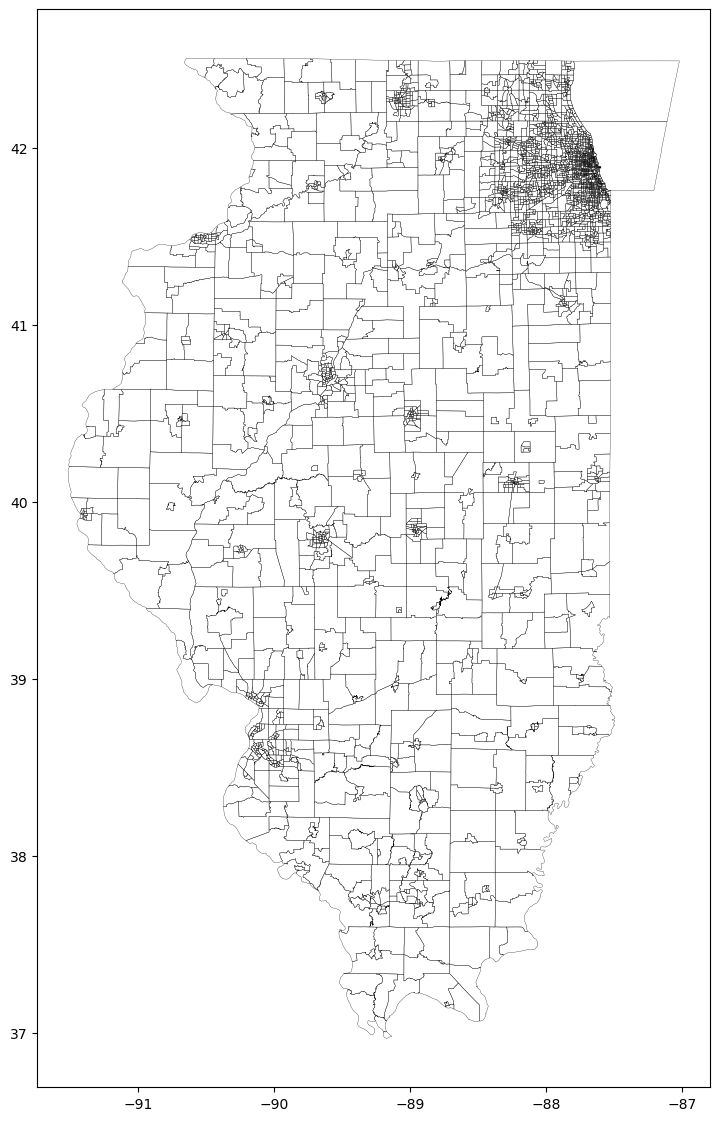

In [155]:
fig_width = 14

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = il_tract_gdf.plot(facecolor="none", edgecolor="black", linewidth=0.015 * fig_width, ax=ax)

Census tracts sized to have roughly comparable total populations. Looking at the tract boundaries on the map, it's neat to see all the little pockets of density across the state. Also, it's interesting to see just how much more densly populated Chicagoland is than the rest of the state; it doesn't feel so packed.

In [129]:
il_tract_gdf.head(2)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17,019,010701,17019010701,107.01,Census Tract 107.01,G5020,S,5266000,30553,+40.1150269,-088.0329549,"POLYGON ((-88.05240 40.11923, -88.05238 40.119..."
1,17,019,005902,17019005902,59.02,Census Tract 59.02,G5020,S,962402,4892,+40.1087344,-088.2247204,"POLYGON ((-88.22891 40.11271, -88.22882 40.112..."


The County FIPS code for Cook County is "031". Let's plot out tracts in Cook County.

In [130]:
cc_tract_gdf = il_tract_gdf.loc[il_tract_gdf["COUNTYFP"] == "031"].copy()

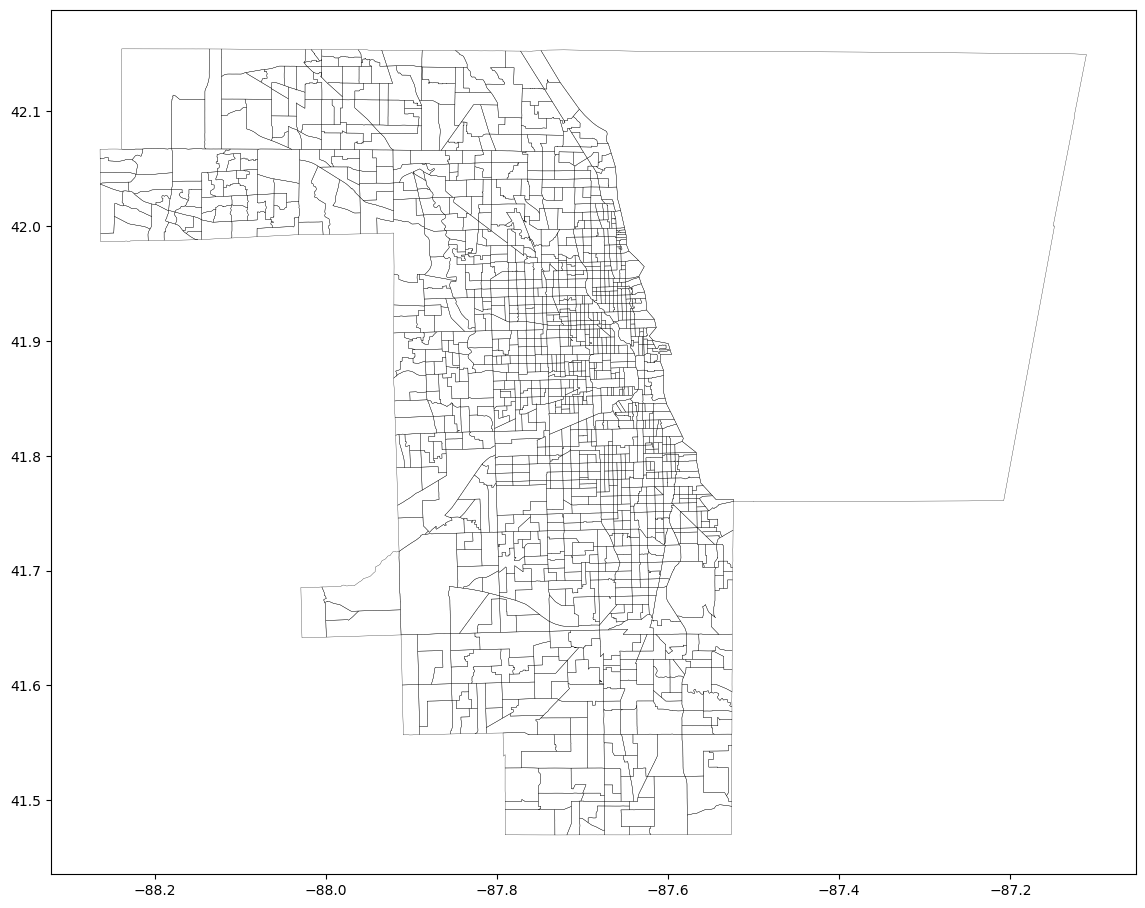

In [133]:
fig_width = 14

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = cc_tract_gdf.plot(facecolor="none", edgecolor="black", linewidth=0.015 * fig_width, ax=ax)

There are also filler tracts with essentially no population that just ensure all US land is covered by a tract.

That really large tract has no area on land, and a very large area over water. Let's filter that out.

In [135]:
cc_tract_gdf["ALAND"].min()

0

In [139]:
cc_tract_gdf.loc[cc_tract_gdf["ALAND"] == 0]

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
1531,17,031,990000,17031990000,9900,Census Tract 9900,G5020,S,0,1717072182,+41.9739391,-087.4002947,"POLYGON ((-87.74156 42.15323, -87.72176 42.153..."


<Axes: >

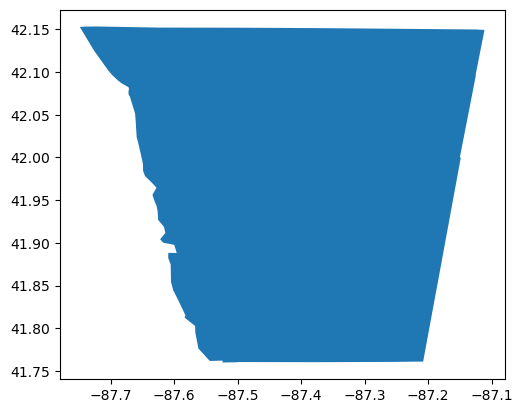

In [138]:
cc_tract_gdf.loc[cc_tract_gdf["ALAND"] == 0].plot()

In [140]:
cc_tract_land_gdf = cc_tract_gdf.loc[cc_tract_gdf["ALAND"] > 0].copy()

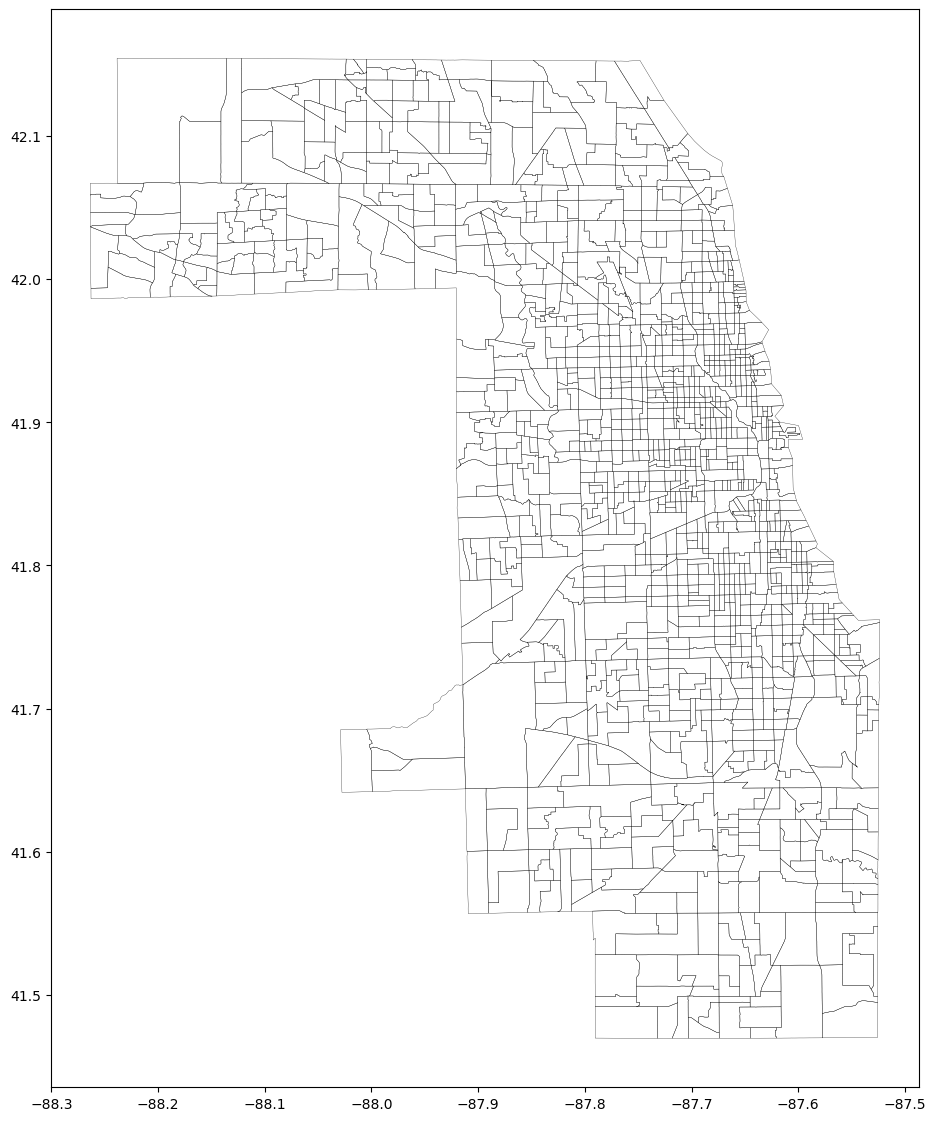

In [141]:
fig_width = 14

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = cc_tract_land_gdf.plot(facecolor="none", edgecolor="black", linewidth=0.015 * fig_width, ax=ax)

## US Rails

In [157]:
tiger22_rails_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_rails_url)

In [158]:
print(tiger22_rails_df.shape)
tiger22_rails_df.head(2)

(1, 8)


,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
1,tl_2022_us_rails.zip,2022-10-31 19:41:00,32M,,False,tl_2022_us_rails.zip,True,https://www2.census.gov/geo/tiger/TIGER2022/RA...


In [159]:
rails22_file_path = download_file_from_single_row_metadata_df(file_df=tiger22_rails_df)

file name: tl_2022_us_rails.zip
url:       https://www2.census.gov/geo/tiger/TIGER2022/RAILS/tl_2022_us_rails.zip


In [160]:
rails22_gdf = gpd.read_file(rails22_file_path)

In [161]:
print(rails22_gdf.shape)
rails22_gdf.head(2)

(124883, 4)


,LINEARID,FULLNAME,MTFCC,geometry
0,11020239500,Norfolk Southern Rlwy,R1011,"LINESTRING (-79.47058 35.44283, -79.46946 35.4..."
1,11020239501,Norfolk Southern Rlwy,R1011,"LINESTRING (-79.46687 35.44789, -79.46762 35.4..."


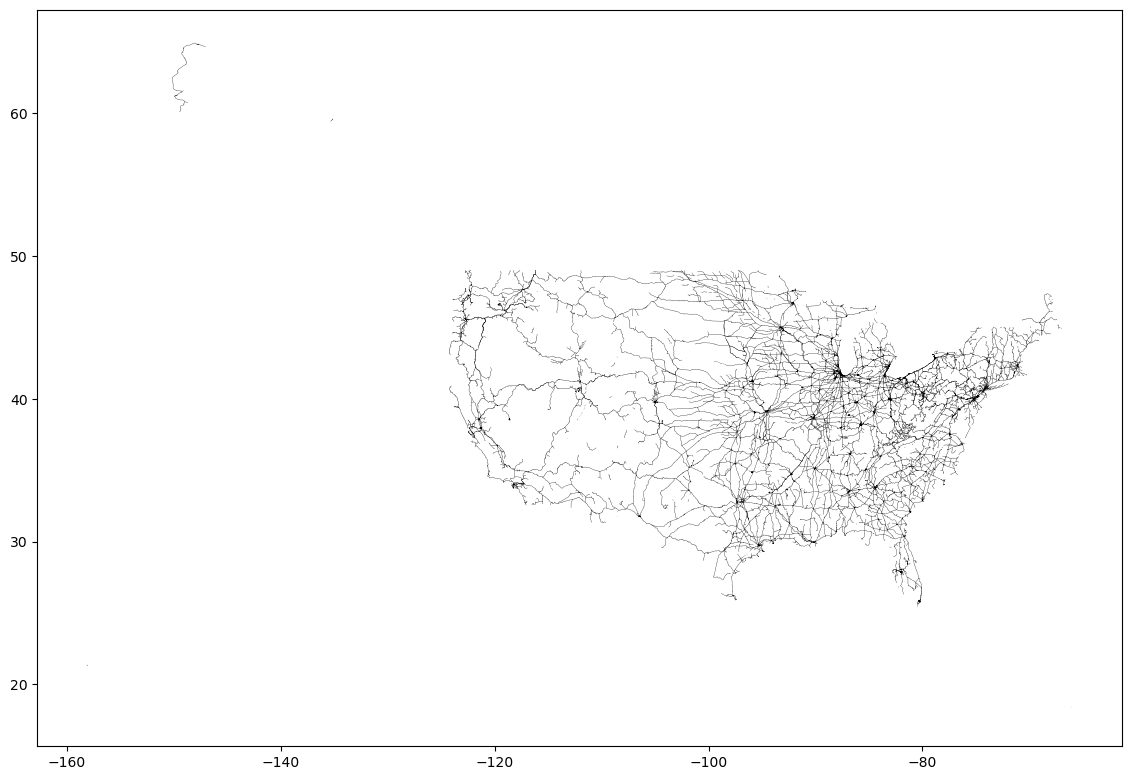

In [162]:
fig_width = 14

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = rails22_gdf.plot(facecolor="none", edgecolor="black", linewidth=0.015 * fig_width, ax=ax)

Ok, let's see if we can figure out a pattern in the ID values.

I can't tell if there's a pattern in the `LINEAR_ID` id values, but filtering on the extents of the geometries works well enough.

In [193]:
il_mask = (
    (rails22_gdf["geometry"].geometry.bounds.maxx > -91.5) &
    (rails22_gdf["geometry"].geometry.bounds.minx < -87) &
    (rails22_gdf["geometry"].geometry.bounds.miny > 36.8) &
    (rails22_gdf["geometry"].geometry.bounds.maxy < 42.5)
)
rails22_gdf.loc[il_mask]

,LINEARID,FULLNAME,MTFCC,geometry
2493,11062564039,Burlington Northern Santa Fe Rlwy,R1011,"LINESTRING (-91.43624 40.58459, -91.43717 40.5..."
2495,11062564041,Burlington Northern Santa Fe Rlwy,R1011,"LINESTRING (-91.22472 40.71766, -91.22282 40.7..."
2496,11062564042,Burlington Northern Santa Fe Rlwy,R1011,"LINESTRING (-91.40103 40.38701, -91.40241 40.3..."
2497,11062564043,Burlington Northern Santa Fe Rlwy,R1011,"LINESTRING (-91.23146 40.70616, -91.23101 40.7..."
2498,11062564044,Burlington Northern Santa Fe Rlwy,R1011,"LINESTRING (-91.22472 40.71766, -91.22478 40.7..."
...,...,...,...,...
124629,11030539241297,Indiana Harbor Belt RR,R1011,"LINESTRING (-87.52505 41.62898, -87.52568 41.6..."
124630,11030539241298,Chicago South Shore & South Bend RR,R1011,"LINESTRING (-87.59632 41.70761, -87.59657 41.7..."
124631,11030539241299,Chicago South Shore & South Bend RR,R1011,"LINESTRING (-87.60260 41.66973, -87.60255 41.6..."
124657,11030539624884,Missouri Pacific RR,R1011,"LINESTRING (-88.32004 39.78122, -88.32012 39.7..."


Let's get the state boundary from those tract boundaries.

In [194]:
il_state_boundary = il_tract_gdf.copy()
il_state_boundary = il_state_boundary.dissolve(by="STATEFP")
il_state_boundary

,geometry,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
STATEFP,,,,,,,,,,,,
17,"POLYGON ((-90.37195 38.31979, -90.37160 38.321...",019,010701,17019010701,107.01,Census Tract 107.01,G5020,S,5266000,30553,+40.1150269,-088.0329549


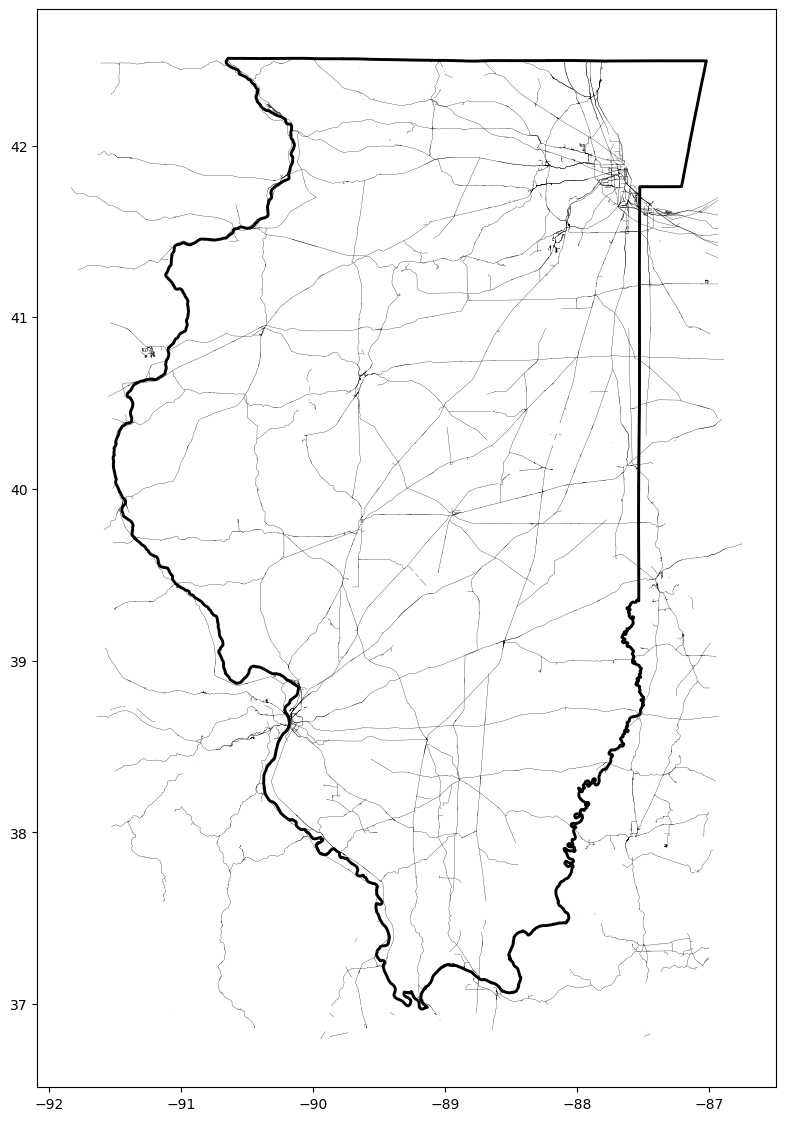

In [195]:
fig_width = 14

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = rails22_gdf.loc[il_mask].plot(facecolor="none", edgecolor="black", linewidth=0.015 * fig_width, ax=ax)
ax = il_state_boundary.plot(facecolor="none", edgecolor="black", linewidth=0.15 * fig_width, ax=ax)

In [196]:
rails22_gdf.head(2)

,LINEARID,FULLNAME,MTFCC,geometry
0,11020239500,Norfolk Southern Rlwy,R1011,"LINESTRING (-79.47058 35.44283, -79.46946 35.4..."
1,11020239501,Norfolk Southern Rlwy,R1011,"LINESTRING (-79.46687 35.44789, -79.46762 35.4..."


In [192]:
rails22_gdf["MTFCC"].value_counts(dropna=False)

MTFCC
R1011    124883
Name: count, dtype: int64

That's not very interesting. Maybe I should investigate that `FEATNAMES` file.

## Feature Names

In [198]:
tiger22_feature_names_url

'https://www2.census.gov/geo/tiger/TIGER2022/FEATNAMES'

In [199]:
tiger22_feat_names_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_feature_names_url)

In [200]:
print(tiger22_feat_names_df.shape)
tiger22_feat_names_df.head(2)

(3235, 8)


,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
1,tl_2022_01001_featnames.zip,2022-10-31 16:05:00,300K,,False,tl_2022_01001_featnames.zip,True,https://www2.census.gov/geo/tiger/TIGER2022/FE...
2,tl_2022_01003_featnames.zip,2022-10-31 16:05:00,888K,,False,tl_2022_01003_featnames.zip,True,https://www2.census.gov/geo/tiger/TIGER2022/FE...


In [202]:
cc_feat_names_df = tiger22_feat_names_df.loc[tiger22_feat_names_df["name"].str.contains("_17031_")].copy()

In [203]:
cc_feat_names_file_path = download_file_from_single_row_metadata_df(file_df=cc_feat_names_df)

file name: tl_2022_17031_featnames.zip
url:       https://www2.census.gov/geo/tiger/TIGER2022/FEATNAMES/tl_2022_17031_featnames.zip


In [204]:
from zipfile import ZipFile

In [210]:
with ZipFile(cc_feat_names_file_path, "r") as zf:
    for fn in zf.filelist:
        print(fn)

<ZipInfo filename='tl_2022_17031_featnames.cpg' filemode='-rwxrwxr-x' file_size=5>
<ZipInfo filename='tl_2022_17031_featnames.dbf' compress_type=deflate filemode='-rwxrwxr-x' file_size=128309798 compress_size=5694237>
<ZipInfo filename='tl_2022_17031_featnames.shp.ea.iso.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=55251 compress_size=3165>
<ZipInfo filename='tl_2022_17031_featnames.shp.iso.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=39111 compress_size=5721>


Ok, so it's just a shapefile like everything else. I guess that makes sense. But it looks like none of the records have a non-null geometry value.

In any case, there's a `LINEARID` feature, just like in the rails data, so I suspect I'll be able to join this to records with linear geometries. And I assume `TLID` stands for "Topological" (maybe?).

In [211]:
cc_feat_names_gdf = gpd.read_file(cc_feat_names_file_path)

In [212]:
print(cc_feat_names_gdf.shape)
cc_feat_names_gdf.head(2)

(310676, 19)


,TLID,FULLNAME,NAME,PREDIRABRV,PRETYPABRV,PREQUALABR,SUFDIRABRV,SUFTYPABRV,SUFQUALABR,PREDIR,PRETYP,PREQUAL,SUFDIR,SUFTYP,SUFQUAL,LINEARID,MTFCC,PAFLAG,geometry
0,111771547,47th Pl Exd,47th,NaN,NaN,NaN,NaN,Pl,Exd,NaN,NaN,NaN,NaN,472,16,110380277026,S1400,A,None
1,112385480,Edens Expy Spr,Edens,NaN,NaN,NaN,NaN,Expy,Spr,NaN,NaN,NaN,NaN,262,24,1104259027148,S1100,A,None


In [214]:
cc_feat_names_gdf["geometry"].notnull().sum()

0

## Roads

In [215]:
tiger22_roads_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_roads_url)

In [217]:
print(tiger22_roads_df.shape)
tiger22_roads_df.head(2)

(3233, 8)


,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
1,tl_2022_01001_roads.zip,2022-10-31 16:05:00,937K,,False,tl_2022_01001_roads.zip,True,https://www2.census.gov/geo/tiger/TIGER2022/RO...
2,tl_2022_01003_roads.zip,2022-10-31 16:05:00,2.2M,,False,tl_2022_01003_roads.zip,True,https://www2.census.gov/geo/tiger/TIGER2022/RO...


In [218]:
cc_roads22_df = tiger22_roads_df.loc[tiger22_roads_df["name"].str.contains("_17031_")].copy()
cc_roads22_df

,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
613,tl_2022_17031_roads.zip,2022-10-31 16:46:00,14M,,False,tl_2022_17031_roads.zip,True,https://www2.census.gov/geo/tiger/TIGER2022/RO...


In [219]:
cc_roads22_file_path = download_file_from_single_row_metadata_df(file_df=cc_roads22_df)

file name: tl_2022_17031_roads.zip
url:       https://www2.census.gov/geo/tiger/TIGER2022/ROADS/tl_2022_17031_roads.zip


In [220]:
cc_roads22_gdf = gpd.read_file(cc_roads22_file_path)

In [221]:
print(cc_roads22_gdf.shape)
cc_roads22_gdf.head(2)

(76017, 5)


,LINEARID,FULLNAME,RTTYP,MTFCC,geometry
0,110380277026,47th Pl Exd,M,S1400,"LINESTRING (-87.59577 41.81461, -87.59570 41.8..."
1,1104259027148,Edens Expy Spr,M,S1100,"LINESTRING (-87.86543 42.14969, -87.86394 42.1..."


In [ ]:
cc_roads22_gdf

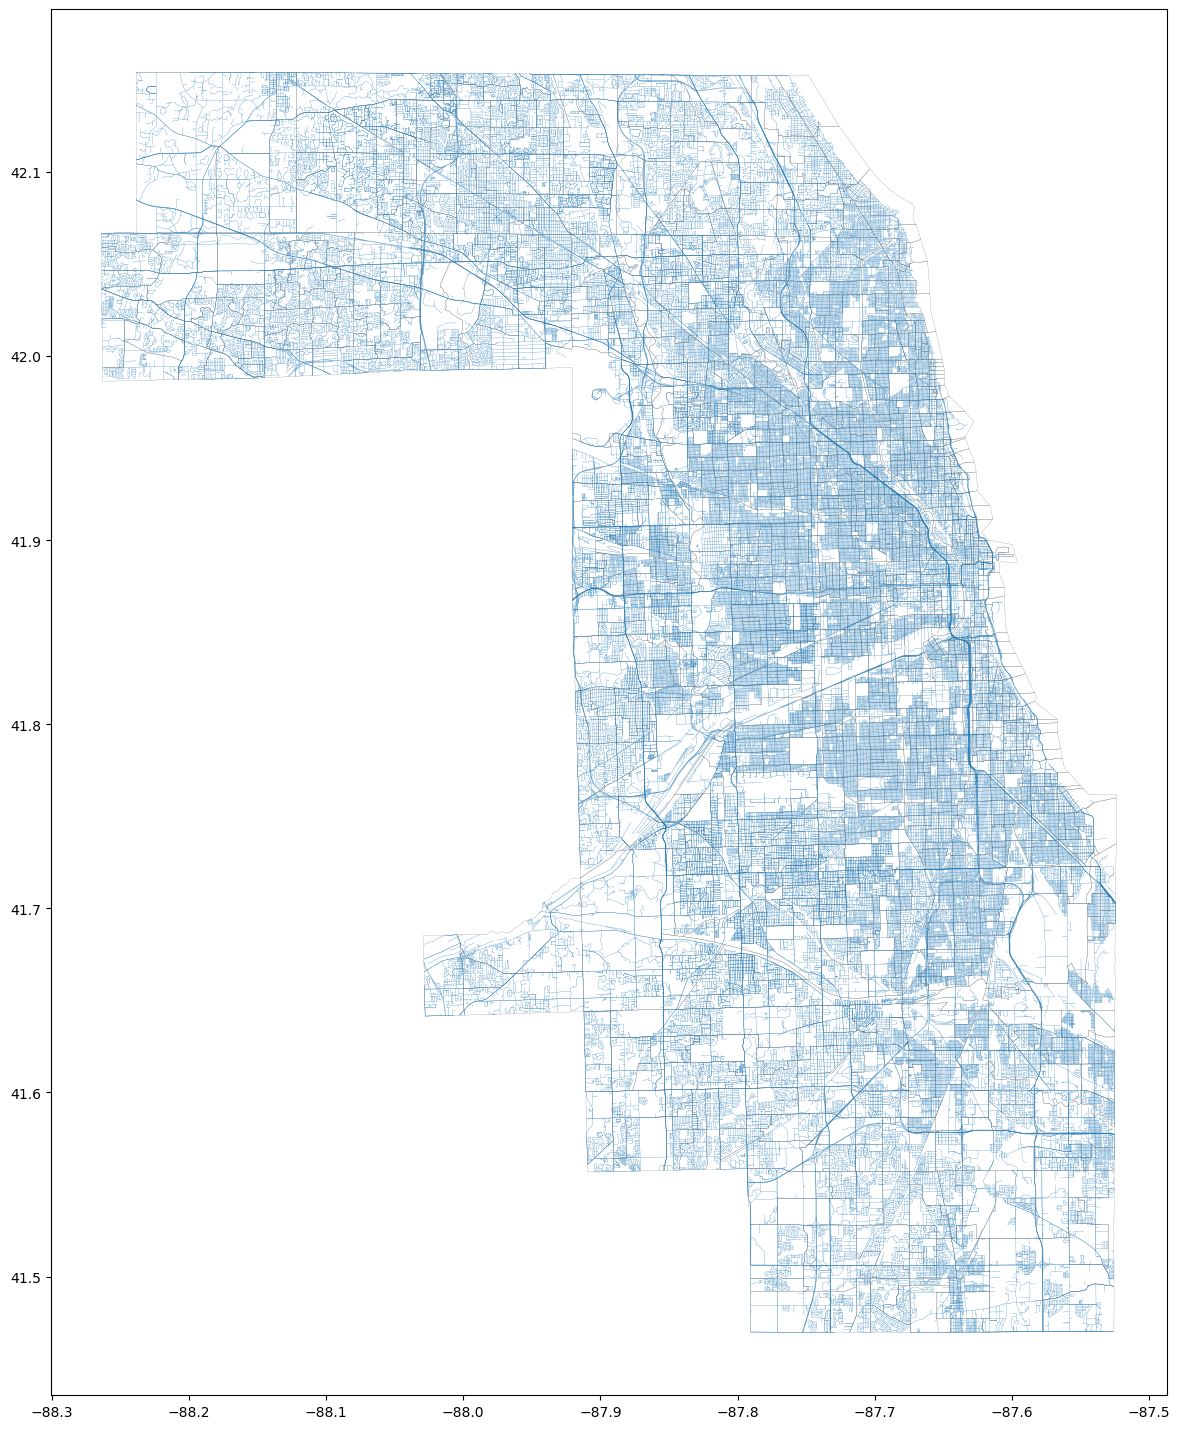

In [223]:
fig_width = 18

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = cc_tract_land_gdf.plot(facecolor="none", edgecolor="black", linewidth=0.005 * fig_width, ax=ax)
ax = cc_roads22_gdf.plot(linewidth=0.01 * fig_width, ax=ax)

## ToDo:
There's more to investigate, but I'll put a pin in this for now.

Also, I should refactor to facilitate easy pipeline rollouts.